In [106]:
# Importing Packages Required for This Chapter
%matplotlib inline
import time
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RANSACRegressor, LinearRegression,TheilSenRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error,mean_squared_error, median_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import seaborn
from IPython.display import Image

In [107]:
data = pd.read_csv('/content/Concrete_Data.csv')
print (len(data))
data.head()

1030


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


From the results, it's noticeable that:

Age--- Integer


All other values-----Float 


Moreover, it is also noticeable that the concrete
data within the dataset can be a year old (i.e., row no. 3 has an age of 365 ~ year)

In [108]:
#Renaming the Columns
data.columns = ['cement_component', 'furnace_slag', 'fly_ash',
'water_component', 'superplasticizer', \
'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']

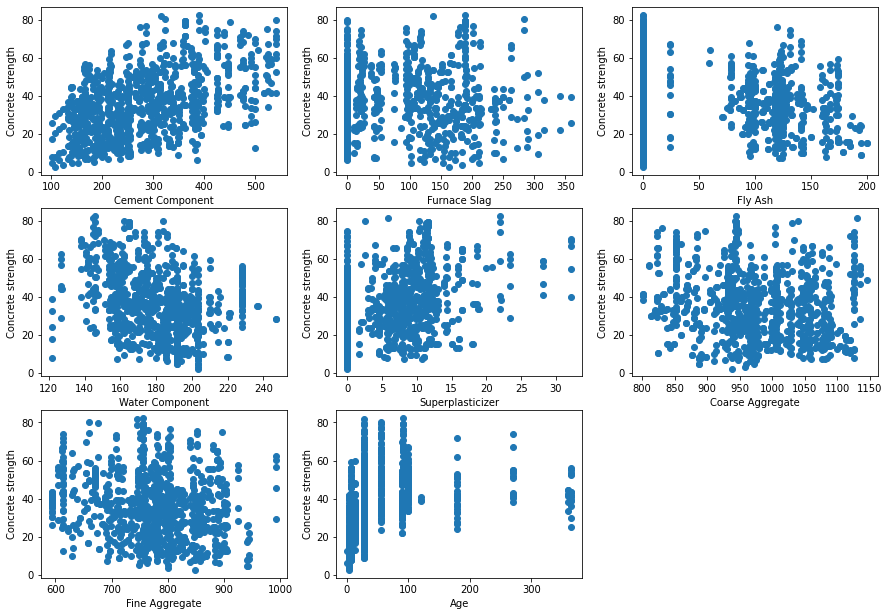

In [109]:
#Plotting Scatter Plots Between the Response and Exploratory Variables
plt.figure(figsize=(15,10.5))
plot_count = 1
for feature in list(data.columns)[:-1]:
  plt.subplot(3,3,plot_count)
  plt.scatter(data[feature], data['concrete_strength'])
  plt.xlabel(feature.replace('_',' ').title())
  plt.ylabel('Concrete strength')
  plot_count+=1
plt.show()

As 

*   strong positive correlation has a value of 1, 
*   strong negative correlation has a value of -1
*   0 indicates no correlation.

From the graph, assumed that there isn't any correlation b/w age and concrete strength

In [110]:
#Calculating Pair-wise Pearson Correlations
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
correlations = data.corr(method='pearson')
correlations

,cement_component,furnace_slag,fly_ash,water_component,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_strength
cement_component,1.000,-0.275,-0.397,-0.082,0.092,-0.109,-0.223,0.082,0.498
furnace_slag,-0.275,1.000,-0.324,0.107,0.043,-0.284,-0.282,-0.044,0.135
fly_ash,-0.397,-0.324,1.000,-0.257,0.378,-0.010,0.079,-0.154,-0.106
water_component,-0.082,0.107,-0.257,1.000,-0.658,-0.182,-0.451,0.278,-0.290
superplasticizer,0.092,0.043,0.378,-0.658,1.000,-0.266,0.223,-0.193,0.366
coarse_aggregate,-0.109,-0.284,-0.010,-0.182,-0.266,1.000,-0.178,-0.003,-0.165
fine_aggregate,-0.223,-0.282,0.079,-0.451,0.223,-0.178,1.000,-0.156,-0.167
age,0.082,-0.044,-0.154,0.278,-0.193,-0.003,-0.156,1.000,0.329
concrete_strength,0.498,0.135,-0.106,-0.290,0.366,-0.165,-0.167,0.329,1.000


From the statistical results 
there exists a slight positive correlation between the two quantities. Visual deduction is prone to human error so we will go with the latter (that's why there’s a slight positive correlation between the two quantities).

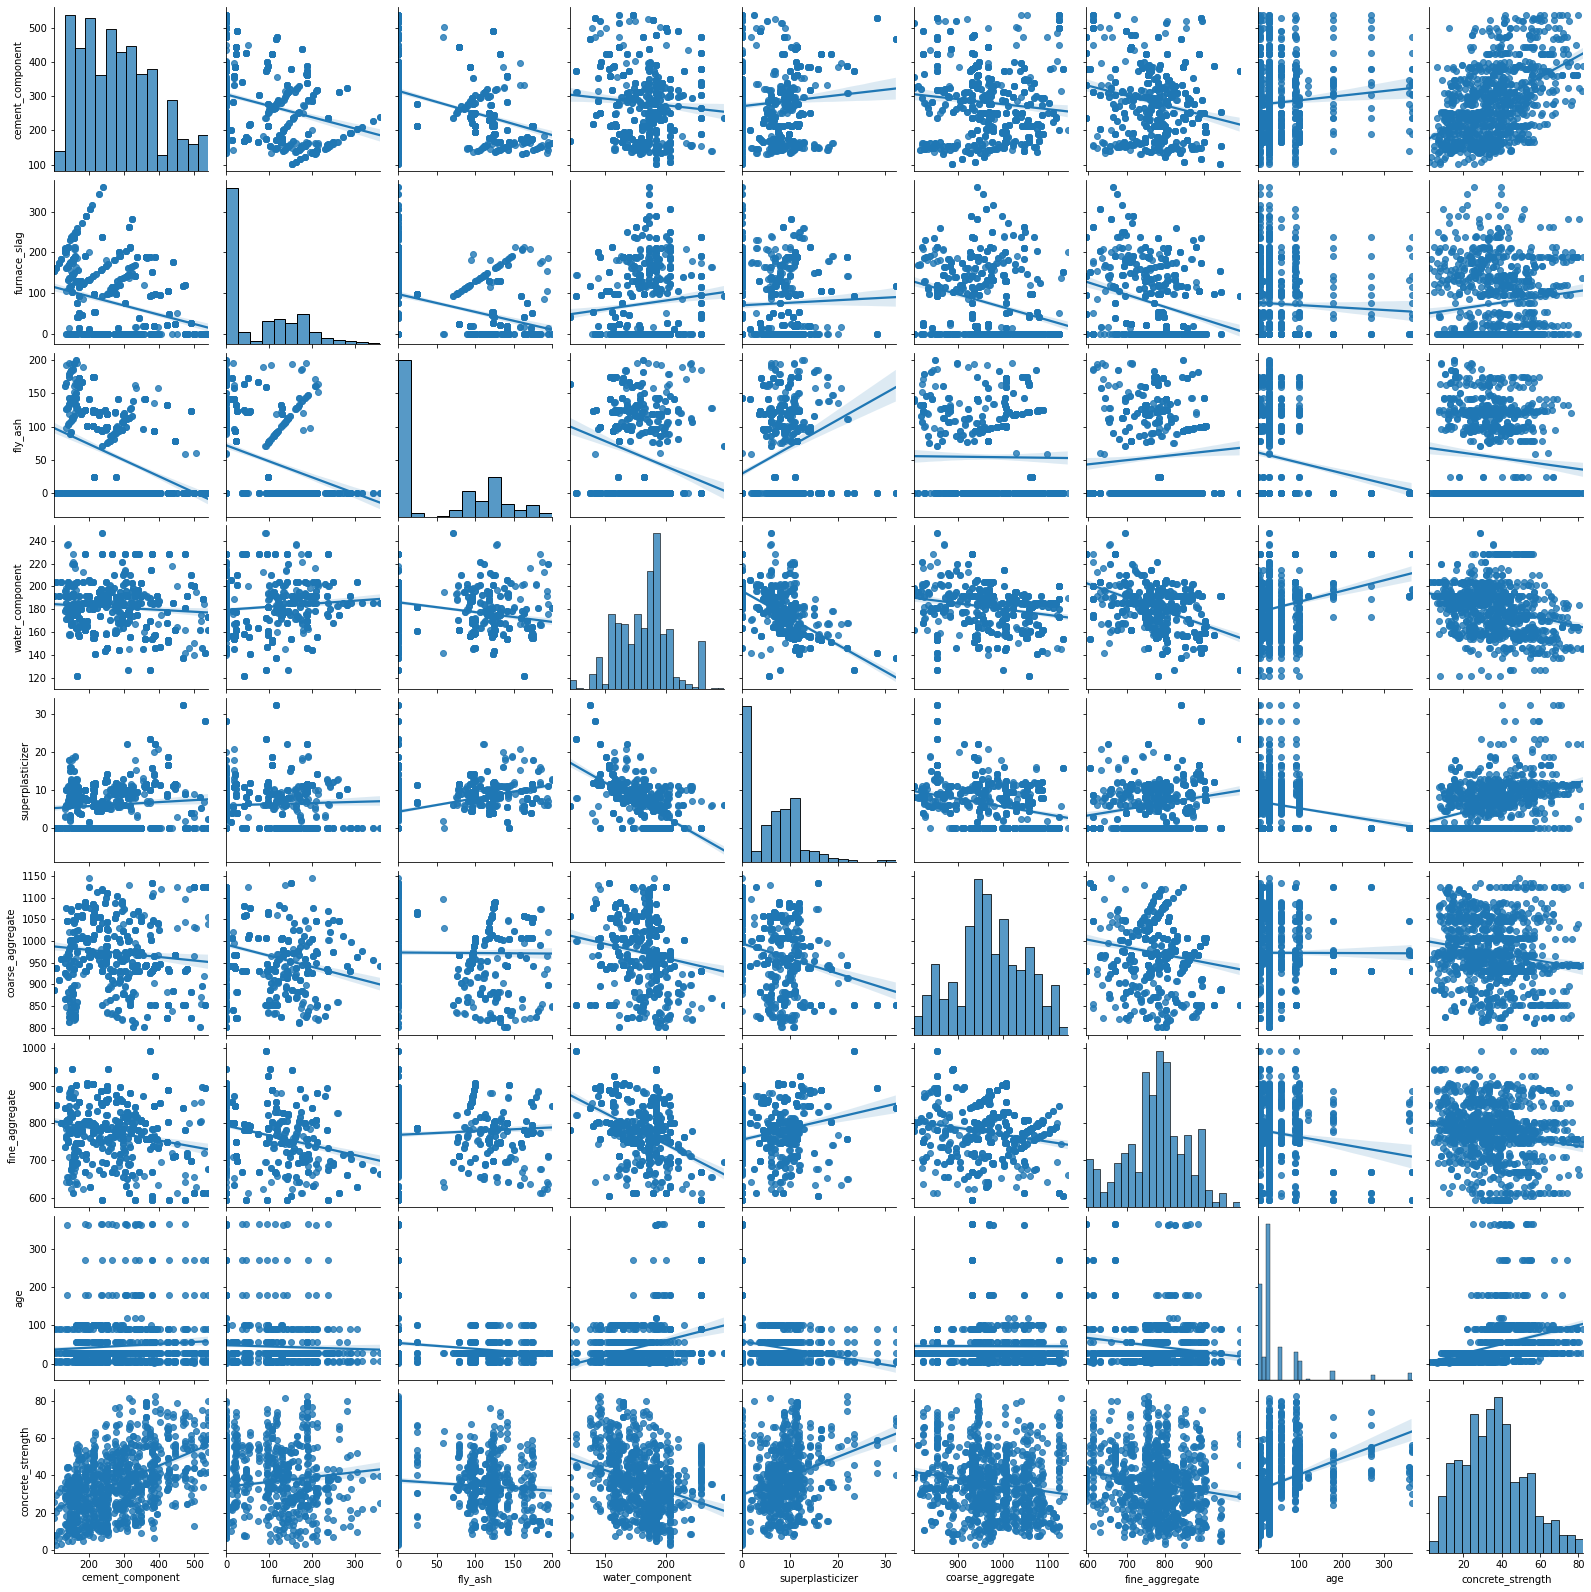

In [111]:
#Calculating Pair Plot Between All Features
#having a majority of 0 values in the dataset can lead to correlation coefficients and 
#regression lines that do not cover the dataset in its true essence.
data_ = data[(data.T != 0).any()] #Removing the records in column having value 0 
seaborn. pairplot(data_, vars=data.columns, kind='reg')
plt.show()

In [112]:
#Splitting the Data in Training and Testing sets
def split_train_test(data, feature, train_index=0.7):
  train, test = train_test_split(data, test_size = 1-train_index)
  if type(feature) == list:
    x_train = train[feature].as_matrix()
    y_train = train['concrete_strength'].as_matrix()
    x_test = test[feature].as_matrix()
    y_test = test['concrete_strength'].as_matrix()
  else:
    x_train = [[x] for x in list(train[feature])]
    y_train = [[x] for x in list(train['concrete_strength'])]
    x_test = [[x] for x in list(test[feature])]
    y_test = [[x] for x in list(test['concrete_strength'])]
  return x_train, y_train, x_test, y_test



cement_component 0.2897924122078658
fly_ash 0.044807508429553944
water_component 0.08413461927043298
superplasticizer 0.08251222451499063
coarse_aggregate 0.021604108543114564


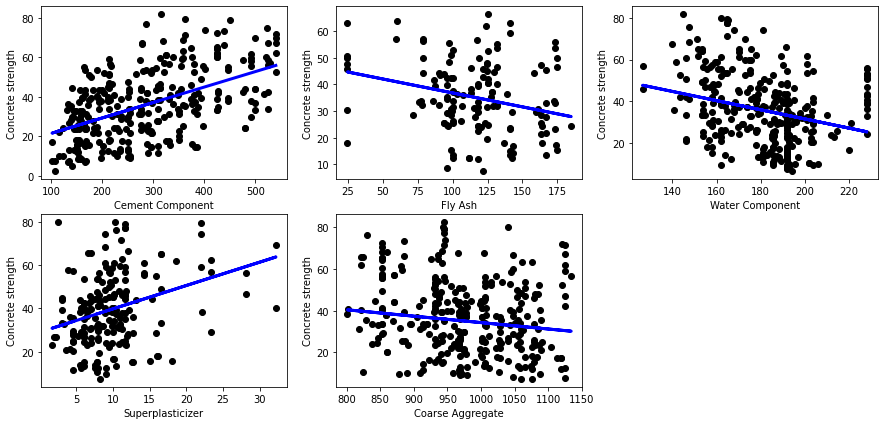

In [113]:
#Calculating Single Linear Regression
plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'fly_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
  data_tr = data[['concrete_strength', feature]]
  data_tr=data_tr[(data_tr.T != 0).all()]
  x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
  # Create linear regression object
  regr = LinearRegression()
  # Train the model using the training sets
  regr.fit(x_train, y_train)
  y_pred = regr.predict(x_test)
  # Plot outputs
  plt.subplot(2,3,plot_count)
  plt.scatter(x_test, y_test, color='black')
  plt.plot(x_test, y_pred, color='blue',linewidth=3)
  plt.xlabel(feature.replace('_',' ').title())
  plt.ylabel('Concrete strength')
  print (feature, r2_score(y_test, y_pred))
  plot_count+=1
plt.show()

As we observed that all the exploratory variables have their R^2 values approximately equal to 0. So the Linear Regression best fit line failed to capture the variance that lay within each of these.

Features: cement_component
R2 score: 0.273653
Intercept: 26.433439
Coefficients: [[0.04977132]]
Features: fly_ash
R2 score: -0.011287
Intercept: 48.257660
Coefficients: [[-0.08194848]]
Features: water_component
R2 score: 0.055858
Intercept: 64.212692
Coefficients: [[-0.14819835]]
Features: superplasticizer
R2 score: 0.051911
Intercept: 32.042456
Coefficients: [[0.76669147]]
Features: coarse_aggregate
R2 score: -0.111212
Intercept: 63.665546
Coefficients: [[-0.02630293]]


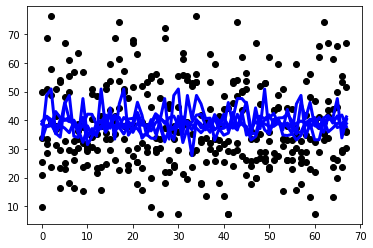

In [114]:
#Calculating Multiple Linear Regression
for features in ['cement_component', 'fly_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
  data_tr = data
  data_tr=data_tr[(data_tr.T != 0).all()]
  x_train, y_train, x_test, y_test = split_train_test(data_tr, features)
  # Create linear regression object
  regr = LinearRegression()
  # Train the model using the training sets
  regr.fit(x_train, y_train)
  y_pred = regr.predict(x_test)
  plt.scatter(range(len(y_test)), y_test, color='black')
  plt.plot(y_pred, color='blue', linewidth=3)
  print ('Features: %s'%str(features))
  print ('R2 score: %f'%r2_score(y_test, y_pred))
  print ('Intercept: %f'%regr.intercept_)
  print ('Coefficients: %s'%str(regr.coef_))

Since the R2 for this multiple regression is extremely low.So, this model cannot be used to predict the response variable (i.e., concrete strength).
However, the output also gives us the coefficients. The first is the alpha coefficient, with the subsequent ones representing the beta coefficients. The multicollinearity exists in the data. Hence in the pursuit of finding regression techniques which work on a multicollinear data, came across Ridge
regression and decided to try that out.

Features: coarse_aggregate
R2 score: -0.111212
Intercept: 63.665546
Coefficients: [[-0.02630293]]


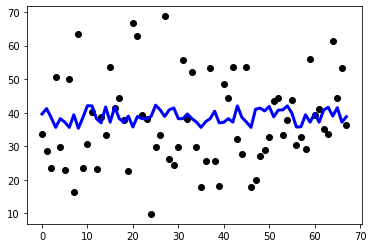

In [115]:
#Calculating Multiple Ridge Regression
alphas = np.arange(0.1,5,0.1)#array of values in the range of 0.1 to 5, with an offset of 0.1.
model = Ridge()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
y_pred = cv.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))
print ('Intercept: %f'%regr.intercept_)
print ('Coefficients: %s'%str(regr.coef_))

Ridge regression even after parameter didn’t bring any improvement over what a multiple linear regression had to offer. so, it is believed that changing the regularization term from L2-norm to L1-norm might bring some improvements to the R2 score.

Features: coarse_aggregate
R2 score: -0.107619
Intercept: 63.665546
Coefficients: [[-0.02630293]]


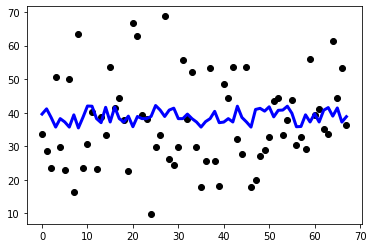

In [116]:
#Calculating Multiple Lasso Regression
model = Lasso()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
y_pred = cv.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))
print ('Intercept: %f'%regr.intercept_)
print ('Coefficients: %s'%str(regr.coef_))


Lasso regression fared better than multiple Ridge and linear regressions. decided. To bring in the best of the regressions.ElasticNet brings in an amalgam of both of these two approaches (i.e., Ridge and Lasso).

Features: coarse_aggregate
R2 score: -0.109364
Intercept: 63.665546
Coefficients: [[-0.02630293]]


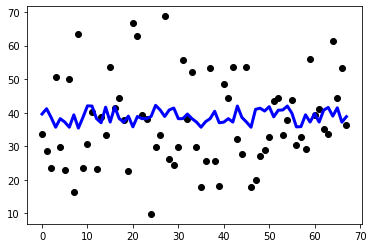

In [117]:
#Calculating Multiple ElasticNet Regression
model = ElasticNet()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
y_pred = cv.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))
print ('Intercept: %f'%regr.intercept_)
print ('Coefficients: %s'%str(regr.coef_))

The cross-validation seemed to be lower here as compared to Lasso regression. As we read earlier, Lasso seems to consider a chunk of the exploratory variables; hence the ElasticNet’s efforts in adding both of them together nullifies the advantage that Lasso had in isolation. This is the behavior we saw on the data at hand but beware it doesn’t stand universal for all problem. 
So, we use another technique that iteratively improves the accuracy of a regression model. Claire knew the answer to that (i.e., gradient boosting regression).

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

cement_component 0.33835071534537275
fly_ash 0.03819382077432043
water_component 0.28982782211343716
superplasticizer 0.1250091763321194


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


coarse_aggregate 0.25745606749898564


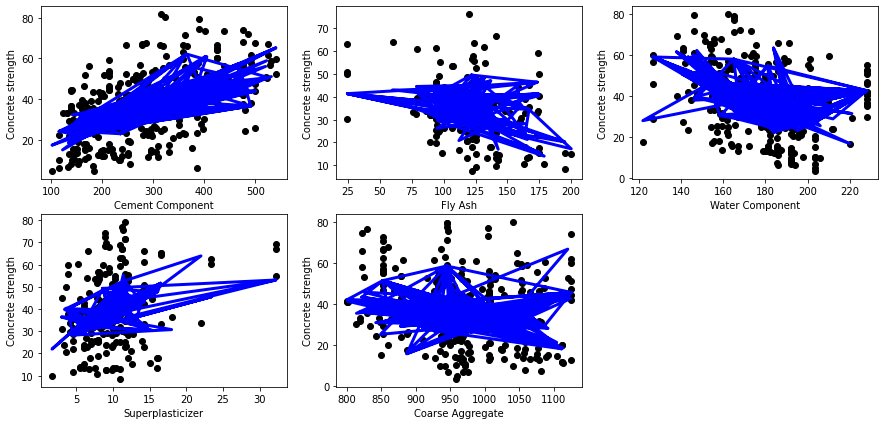

In [118]:
#Calculating Single Gradient Boosting Regression
plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'fly_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
  data_tr = data[['concrete_strength', feature]]
  data_tr=data_tr[(data_tr.T != 0).all()]
  x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
  # Create linear regression object
  regr = GradientBoostingRegressor()
  # Train the model using the training sets
  regr.fit(x_train, y_train)
  y_pred = regr.predict(x_test)
  # Plot outputs
  plt.subplot(2,3,plot_count)
  plt.scatter(x_test, y_test, color='black')
  plt.plot(x_test, y_pred, color='blue',linewidth=3)
  plt.xlabel(feature.replace('_',' ').title())
  plt.ylabel('Concrete strength')
  print (feature, r2_score(y_test,y_pred))
  plot_count+=1
plt.show()

As observed that, the R2 coefficient of the regression model improves significantly.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features: coarse_aggregate
R2 score: 0.257456


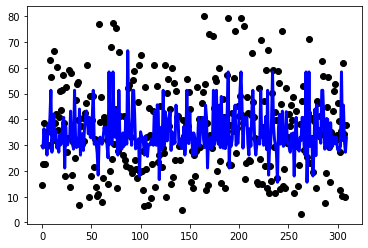

In [119]:
#Calculating Multiple Gradient Boosting Regression
model = GradientBoostingRegressor()
y_pred = model.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue',linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))
#print ('Intercept: %f'%regr.intercept_)
#print ('Coefficients: %s'%str(regr.coef_))

The R2 go from bad to worse. Single gradient boosting regression seems to have fared better than multiple gradient boosting regression.
To better classify or extrapolate the data, one approach can be to plot the data in a high-dimensional space. Support vector machines tend to do that
in the presence of kernels.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cement_component 0.23530335157268212
fly_ash 0.08179648673660722


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


water_component 0.059304511254483216
superplasticizer 0.029976622871699


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


coarse_aggregate 0.03881419041285006


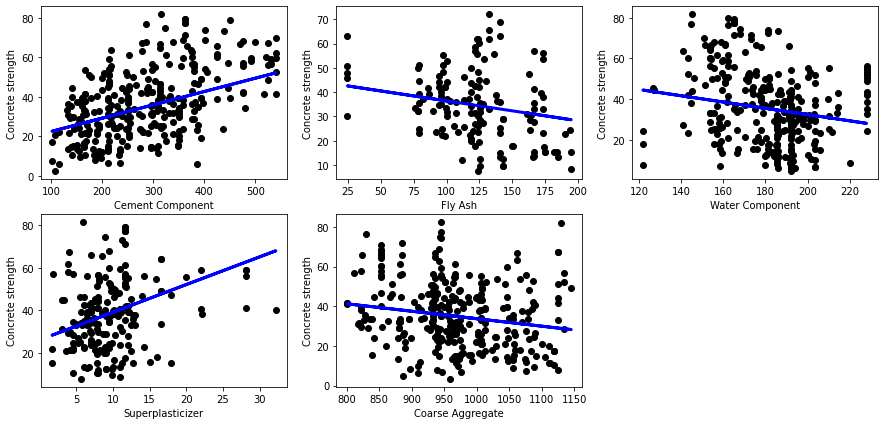

In [120]:
#Calculating Single Support Vector Machine Regression Using Linear Kernel
plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'fly_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
  data_tr = data[['concrete_strength', feature]]
  data_tr=data_tr[(data_tr.T != 0).all()]
  x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
  # Create linear regression object
  regr = SVR(kernel='linear')
  # Train the model using the training sets
  regr.fit(x_train, y_train)
  y_pred = regr.predict(x_test)
  # Plot outputs
  plt.subplot(2,3,plot_count)
  plt.scatter(x_test, y_test, color='black')
  plt.plot(x_test, y_pred, color='blue', linewidth=3)
  plt.xlabel(feature.replace('_',' ').title())
  plt.ylabel('Concrete strength')
  print (feature, r2_score(y_test, y_pred))
  plot_count+=1
plt.show()

Contrary to the gradient boosting regressor’s best fit lines in Multiple Lasso Regressor, best fit lines in Single gradient bosting regressor seem to be much cleaner, linear, and relatively less overfitted. However, the R2 got a hit as it decreased from what they observed in single gradient boosting regressor.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features: coarse_aggregate
R2 score: 0.038814


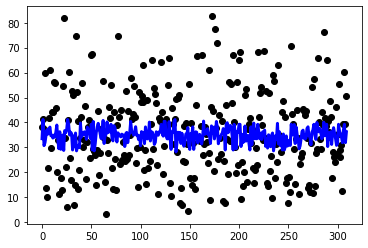

In [121]:
#Calculating Multiple Support Vector Machine Regression Using Linear Kernel
model = SVR(kernel='linear')
y_pred = model.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))

By observing SVR results with previously applied model, it is concluded that the support vector regressor performed the worst among the
models they had explored earlier.

In [128]:
#Predicting Concrete Strength from Cement Component
feature = 'cement_component'
cc_new_data = [213.5]
cc_new_data2=np.array(cc_new_data)[:,np.newaxis]
#cc_new_data =int(cc_new_data[:,np.newaxis])
data_tr = data[['concrete_strength', feature]]
data_tr=data_tr[(data_tr.T != 0).all()]
x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
regr = GradientBoostingRegressor()
# Train the model using the training sets
regr.fit(x_train, y_train)
cs_pred = regr.predict(cc_new_data2)
print ('Predicted value of concrete strength: %f'%cs_pred)

Predicted value of concrete strength: 34.522131


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [123]:
#Predicting Concrete Strength from Water Component
feature = 'water_component'
wc_new_data = [200]
wc_new_data2=np.array(wc_new_data)[:,np.newaxis]
data_tr = data[['concrete_strength', feature]]
data_tr=data_tr[(data_tr.T != 0).all()]
x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
regr = GradientBoostingRegressor()
# Train the model using the training sets
regr.fit(x_train, y_train)
cs_pred = regr.predict(wc_new_data2)
print ('Predicted value of concrete strength: %f'%cs_pred)

Predicted value of concrete strength: 35.625915


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [124]:
#Predicting Concrete Strength from Coarse Aggregate
feature = 'coarse_aggregate'
ca_new_data = [1000]
ca_new_data2=np.array(ca_new_data)[:,np.newaxis]
data_tr = data[['concrete_strength', feature]]
data_tr=data_tr[(data_tr.T != 0).all()]
x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
regr = GradientBoostingRegressor()
# Train the model using the training sets
regr.fit(x_train, y_train)
cs_pred = regr.predict(ca_new_data2)
print ('Predicted value of concrete strength: %f'%cs_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Predicted value of concrete strength: 30.305993
